In [1]:
import qif
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import spearmanr

plt.style.use("seaborn-whitegrid")
%matplotlib inline

In [2]:
from mestrado import datasets

In [3]:
def joint_distribution(df, x, y):
    joint_dist = df.groupby([x, y]).size().unstack()
    joint_dist.columns = joint_dist.columns.get_level_values(0)
    joint_dist = joint_dist.div(joint_dist.sum().sum())
    joint_dist.fillna(0, inplace=True)
    return joint_dist

In [4]:
def compute_leakages(df, x, y):
    """
        Computes the average multiplicative and additive bayes' vulnerability
        and bayes' risk.
    """
    
    J = joint_distribution(df, x, y)
    pi = J.sum(axis=1) # X prior
    C_xy = J.divide(pi, axis=0) # C: X->Y
    sigma = J.sum(axis=0) # Y prior
    C_yx = J.T.divide(sigma, axis=0) # C: Y->X
    
    leakages = {
        'direct_bayes_vuln_mult_leakage': qif.measure.bayes_vuln.mult_leakage(pi, C_xy),
        'reverse_bayes_vuln_mult_leakage': qif.measure.bayes_vuln.mult_leakage(sigma, C_yx),
        'direct_bayes_risk_mult_leakage': qif.measure.bayes_risk.mult_leakage(pi, C_xy),
        'reverse_bayes_risk_mult_leakage': qif.measure.bayes_risk.mult_leakage(sigma, C_yx)
    }

    return leakages

In [5]:
breast_tumor = datasets.load_breast_tumor()
cholesterol = datasets.load_cholesterol()
pbc = datasets.load_pbc()
pollution = datasets.load_pollution()
autompg = datasets.load_autompg()
cpu = datasets.load_cpu()
breastw = datasets.load_breastw()
balance_scale = datasets.load_balance_scale()
servo = datasets.load_servo()
sensory = datasets.load_sensory()
pwlinear = datasets.load_pwlinear()
wisconsin = datasets.load_wisconsin()

In [6]:
databases = {
    'breast_tumor':breast_tumor,
    'cholesterol':cholesterol,
    'pbc':pbc,
    'pollution':pollution,
    'autompg':autompg,
    'cpu':cpu,
    'breastw':breastw,
    'balance_scale':balance_scale,
    'servo':servo,
    'sensory':sensory,
    'pwlinear':pwlinear,
    'wisconsin':wisconsin,
}

In [7]:
databases_ce_pairs = {
    'breast_tumor':[('tumor_size', 'inv_nodes'), ('tumor_size', 'deg_malig')],
    'cholesterol':[('chol', 'trestbps'), ('chol', 'fbs')],
    'pbc':[('stage', 'albumin'), ('stage', 'protime'), ('stage', 'bili')],
    'pollution':[('mort', 'ovr65')],
    'autompg':[('horsepower', 'mpg'), ('weight', 'mpg')],
    'cpu':[('myct', 'erp'), ('mmax', 'erp'), ('cach', 'erp')],
    'breastw':[('target', 'Clump_Thickness'), ('target', 'Cell_Shape_Uniformity'), ('target', 'Cell_Size_Uniformity')],
    'balance_scale':[('left_weight', 'target'), ('right_weight', 'target'), ('left_distance', 'target'), ('right_distance', 'target')],
    'servo':[('pgain', 'class'), ('vgain', 'class')],
    'sensory':[('trellis', 'score')],
    'pwlinear':[(f'a{n}', 'binaryClass') for n in range(1, 11)],
    'wisconsin':[('diagnosis', 'perimeter_mean'), ('diagnosis', 'smoothness_mean'), ('diagnosis', 'concavity_mean')]
}

In [8]:
results = []

for n_bins in tqdm(range(2, 31)):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    for name, df in databases.items():
        for cause, effect in databases_ce_pairs[name]:
            #print(f"df: {name} | cause: {cause} | effect: {effect}")
            if df[cause].dtype.name != 'category':
                df[cause + "_cat"] = est.fit_transform(df[cause].values.reshape(-1, 1))
                cause = cause + "_cat"
                df[cause] = df[cause].astype('category')

            if df[effect].dtype.name != 'category':
                df[effect + "_cat"] = est.fit_transform(df[effect].values.reshape(-1, 1))
                effect = effect + "_cat"
                df[effect] = df[effect].astype('category')

            leakage = compute_leakages(df, cause, effect)
            leakage['dataset'] = name
            leakage['cause'] = cause
            leakage['effect'] = effect
            leakage['n_bins'] = n_bins
            
            corr, p_value = spearmanr(df[cause], df[effect])
            leakage['spearman'] = corr
            leakage['corr_p_value'] = p_value
            results.append(leakage)

100%|██████████| 29/29 [00:03<00:00,  8.64it/s]


In [9]:
df_results = pd.DataFrame(results)

In [10]:
df_results.head()

,direct_bayes_vuln_mult_leakage,reverse_bayes_vuln_mult_leakage,direct_bayes_risk_mult_leakage,reverse_bayes_risk_mult_leakage,dataset,cause,effect,n_bins,spearman,corr_p_value
0,1.116667,1.000000,1.031963,1.000000,breast_tumor,tumor_size,inv_nodes,2,0.183643,0.001817
1,1.116667,1.076923,1.031963,1.068493,breast_tumor,tumor_size,deg_malig,2,0.201513,0.000608
2,1.000000,1.000000,1.000000,1.000000,cholesterol,chol_cat,trestbps_cat,2,0.030888,0.592250
3,1.000000,1.000000,1.000000,1.000000,cholesterol,chol_cat,fbs,2,-0.010889,0.850271
4,1.193548,1.000000,1.133333,1.000000,pbc,stage,albumin_cat,2,NaN,NaN


In [11]:
# plt.figure(figsize=(12, 12))
# x = df_results['direct_bayes_vuln_mult_leakage']
# y = df_results['reverse_bayes_vuln_mult_leakage']
# plt.scatter(x=x, y=y, alpha=2/3)
# plt.plot([0.95, 3.05], [0.95, 3.05], color='black', linewidth=0.5, linestyle='dashed')
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlabel("Direct Bayes Vulnerability Average Multiplicative Leakage", fontsize=16)
# plt.ylabel("Reverse Bayes Vulnerability Average Multiplicative Leakage", fontsize=16)
# plt.tight_layout()
# plt.savefig("bayes_vulnerability_discrete_real_databases.png", dpi=120, transparent=False)


# plt.figure(figsize=(12, 12))
# sns.scatterplot(data=df_results, x='direct_bayes_risk_mult_leakage', y='reverse_bayes_risk_mult_leakage', alpha=2/3)
# plt.plot([0.95, 5], [0.95, 5], color='black', linewidth=0.5, linestyle='dashed')
# plt.show()

In [12]:
causality_datasets = {'breast_tumor':'anticausal', 'cholesterol':'anticausal', 'pbc':'anticausal', 'pollution':'anticausal',
                      'autompg':'causal', 'cpu':'causal', 'breastw':'anticausal', 'balance_scale':'causal', 'servo':'causal',
                      'sensory':'causal', 'pwlinear':'causal', 'wisconsin':'anticausal'}

In [13]:
df_results['label'] = df_results['dataset'].replace(causality_datasets)

In [14]:
df_results_tmp = df_results.copy()

In [15]:
df_results.head()

,direct_bayes_vuln_mult_leakage,reverse_bayes_vuln_mult_leakage,direct_bayes_risk_mult_leakage,reverse_bayes_risk_mult_leakage,dataset,cause,effect,n_bins,spearman,corr_p_value,label
0,1.116667,1.000000,1.031963,1.000000,breast_tumor,tumor_size,inv_nodes,2,0.183643,0.001817,anticausal
1,1.116667,1.076923,1.031963,1.068493,breast_tumor,tumor_size,deg_malig,2,0.201513,0.000608,anticausal
2,1.000000,1.000000,1.000000,1.000000,cholesterol,chol_cat,trestbps_cat,2,0.030888,0.592250,anticausal
3,1.000000,1.000000,1.000000,1.000000,cholesterol,chol_cat,fbs,2,-0.010889,0.850271,anticausal
4,1.193548,1.000000,1.133333,1.000000,pbc,stage,albumin_cat,2,NaN,NaN,anticausal


In [16]:
q_anticausal = df_results_tmp['label'] == 'anticausal'
direct_leakage_anticausal = df_results_tmp[q_anticausal]['reverse_bayes_vuln_mult_leakage'].values
reverse_leakage_anticausal = df_results_tmp[q_anticausal]['direct_bayes_vuln_mult_leakage'].values
df_results_tmp.loc[q_anticausal, 'reverse_bayes_vuln_mult_leakage'] = reverse_leakage_anticausal
df_results_tmp.loc[q_anticausal, 'direct_bayes_vuln_mult_leakage'] = direct_leakage_anticausal

In [17]:
# plt.figure(figsize=(12, 12))
# df_causal = df_results_tmp.query("label == 'causal'")
# df_anticausal = df_results_tmp.query("label == 'anticausal'")
# plt.scatter(x=df_causal['direct_bayes_vuln_mult_leakage'], y=df_causal['reverse_bayes_vuln_mult_leakage'], alpha=2/3, label='causal')
# plt.scatter(x=df_anticausal['direct_bayes_vuln_mult_leakage'], y=df_anticausal['reverse_bayes_vuln_mult_leakage'], alpha=2/3, label='anticausal')
# plt.plot([0.95, 3.05], [0.95, 3.05], color='black', linewidth=0.5, linestyle='dashed')
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlabel("Direct Bayes Vulnerability Average Multiplicative Leakage", fontsize=16)
# plt.ylabel("Reverse Bayes Vulnerability Average Multiplicative Leakage", fontsize=16)
# plt.legend(fontsize=16)
# plt.savefig("bayes_vulnerability_discrete_real_databases_causal_relantion.png", dpi=120, transparent=False)

In [18]:
df_results_tmp['diff_leakage'] = df_results_tmp['direct_bayes_vuln_mult_leakage'] - df_results_tmp['reverse_bayes_vuln_mult_leakage']

In [19]:
df_results_causal = df_results_tmp.query("label == 'causal'").copy()
df_results_anticausal = df_results_tmp.query("label == 'anticausal'").copy()

In [20]:
df_causal_opt = df_results_causal.sort_values(by=['diff_leakage'], ascending=False).drop_duplicates(subset=['dataset', 'cause', 'effect'], keep='first')
df_anticausal_opt = df_results_anticausal.sort_values(by=['diff_leakage']).drop_duplicates(subset=['dataset', 'cause', 'effect'], keep='first')

In [21]:
df_opt = pd.concat([df_causal_opt, df_anticausal_opt])

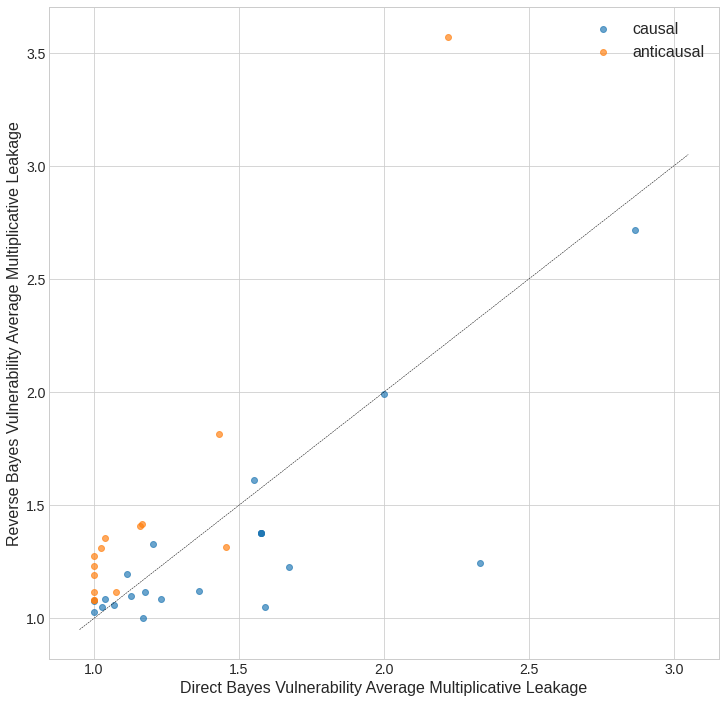

In [22]:
plt.figure(figsize=(12, 12))
df_causal = df_opt.query("label == 'causal'")
df_anticausal = df_opt.query("label == 'anticausal'")
plt.scatter(x=df_causal['direct_bayes_vuln_mult_leakage'], y=df_causal['reverse_bayes_vuln_mult_leakage'], alpha=2/3, label='causal')
plt.scatter(x=df_anticausal['direct_bayes_vuln_mult_leakage'], y=df_anticausal['reverse_bayes_vuln_mult_leakage'], alpha=2/3, label='anticausal')
plt.plot([0.95, 3.05], [0.95, 3.05], color='black', linewidth=0.5, linestyle='dashed')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Direct Bayes Vulnerability Average Multiplicative Leakage", fontsize=16)
plt.ylabel("Reverse Bayes Vulnerability Average Multiplicative Leakage", fontsize=16)
plt.legend(fontsize=16)
plt.savefig("bayes_vulnerability_discrete_real_databases_causal_relantion_optimized.png", dpi=120, transparent=False)

In [23]:
df_opt['y_pred'] = df_opt['diff_leakage'] > 0
df_opt['y_pred'] = df_opt['y_pred'].replace({True:'causal', False:'anticausal'})
df_opt['count_tmp'] = 1

In [24]:
pd.pivot_table(df_opt, values='count_tmp', index='label', columns=['y_pred'], aggfunc=sum)

y_pred,anticausal,causal
label,,
anticausal,13,1
causal,7,15


In [25]:
# plt.figure(figsize=(12, 12))
# plt.scatter(x=df_opt['diff_leakage'], y=df_opt['spearman'])
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlabel("Leakage difference", fontsize=16)
# plt.ylabel("Spearman Correlation", fontsize=16)
# plt.savefig("correlation_and_leakage_difference.png", dpi=120, transparent=False)

In [26]:
df_opt.head()

,direct_bayes_vuln_mult_leakage,reverse_bayes_vuln_mult_leakage,direct_bayes_risk_mult_leakage,reverse_bayes_risk_mult_leakage,dataset,cause,effect,n_bins,spearman,corr_p_value,label,diff_leakage,y_pred,count_tmp
839,2.333333,1.244094,1.576923,1.607843,cpu,mmax_cat,erp_cat,25,0.813501,1.269216e-50,causal,1.089239,causal,1
200,1.590909,1.049180,1.629032,1.153846,servo,pgain,class_cat,7,-0.722000,3.451955e-28,causal,0.541729,causal,1
1029,1.673469,1.226415,1.388235,1.117647,servo,vgain,class_cat,30,-0.328642,1.450010e-05,causal,0.447054,causal,1
310,1.361111,1.121429,1.136842,1.040573,sensory,trellis,score,10,0.087689,3.537695e-02,causal,0.239683,causal,1
307,1.576000,1.378472,1.168224,1.478070,balance_scale,right_distance,target,10,0.358054,2.428825e-20,causal,0.197528,causal,1


In [27]:
df_opt_right = df_opt.query("label == y_pred")
df_opt_wrong = df_opt.query("label != y_pred")

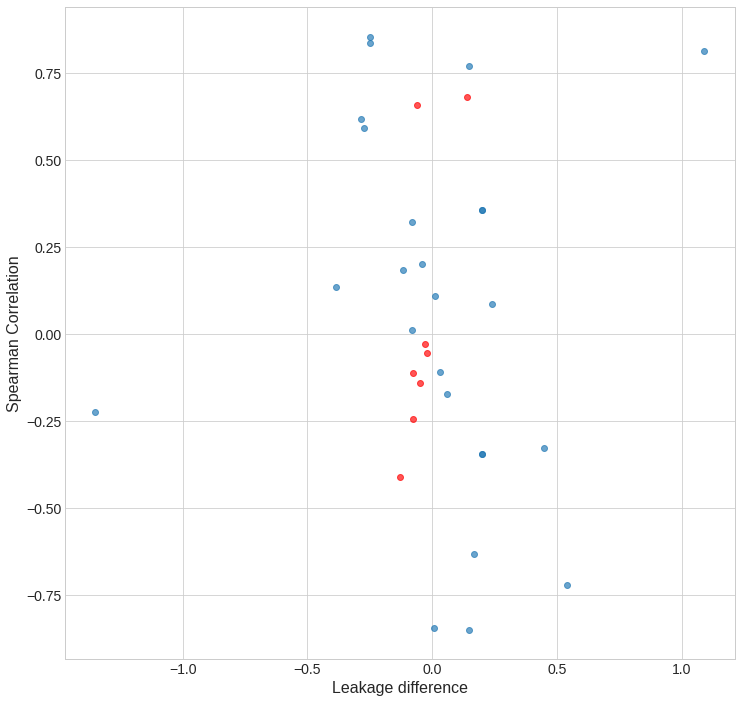

In [28]:
plt.figure(figsize=(12, 12))
plt.scatter(x=df_opt_right['diff_leakage'], y=df_opt_right['spearman'], alpha=2/3)
plt.scatter(x=df_opt_wrong['diff_leakage'], y=df_opt_wrong['spearman'], color='red', alpha=2/3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Leakage difference", fontsize=16)
plt.ylabel("Spearman Correlation", fontsize=16)
plt.show()

In [29]:
df_opt_wrong

,direct_bayes_vuln_mult_leakage,reverse_bayes_vuln_mult_leakage,direct_bayes_risk_mult_leakage,reverse_bayes_risk_mult_leakage,dataset,cause,effect,n_bins,spearman,corr_p_value,label,diff_leakage,y_pred,count_tmp
894,1.027397,1.048544,1.016000,1.054348,pwlinear,a8,binaryClass,26,-0.055124,4.381794e-01,causal,-0.021146,anticausal,1
356,1.000000,1.029126,1.000000,1.031915,pwlinear,a10,binaryClass,11,-0.029359,6.798335e-01,causal,-0.029126,anticausal,1
564,1.039474,1.087379,1.024793,1.102273,pwlinear,a2,binaryClass,17,-0.139206,4.930920e-02,causal,-0.047905,anticausal,1
347,1.551402,1.611650,2.735294,2.852941,pwlinear,a1,binaryClass,11,0.659815,2.272980e-26,causal,-0.060249,anticausal,1
241,1.000000,1.077670,1.000000,1.089888,pwlinear,a3,binaryClass,8,-0.110483,1.193660e-01,causal,-0.077670,anticausal,1
1000,1.115385,1.194175,1.079646,1.259740,pwlinear,a6,binaryClass,29,-0.244495,4.846374e-04,causal,-0.078790,anticausal,1
99,1.202532,1.330097,1.152381,1.539683,pwlinear,a5,binaryClass,4,-0.409791,1.683574e-09,causal,-0.127565,anticausal,1
985,1.455172,1.314410,2.484536,1.135246,breastw,target,Clump_Thickness,29,0.682452,5.848319e-97,anticausal,0.140762,causal,1


In [30]:
pwlinear

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,binaryClass
0,-1,-1,-1,0,0,-1,0,0,0,1,P
1,1,-1,-1,0,0,-1,1,1,1,0,P
2,1,-1,-1,1,0,1,0,-1,-1,1,N
3,-1,1,-1,0,0,1,-1,1,-1,0,N
4,1,-1,-1,0,0,-1,0,-1,1,0,P
...,...,...,...,...,...,...,...,...,...,...,...
195,-1,0,-1,0,0,-1,-1,1,-1,1,N
196,1,-1,0,-1,0,1,0,0,1,-1,P
197,1,-1,-1,-1,0,0,0,1,1,0,P
198,1,0,0,0,1,1,0,-1,-1,1,N


In [32]:
df_opt.sort_values(by=['dataset', 'cause', 'effect'])

,direct_bayes_vuln_mult_leakage,reverse_bayes_vuln_mult_leakage,direct_bayes_risk_mult_leakage,reverse_bayes_risk_mult_leakage,dataset,cause,effect,n_bins,spearman,corr_p_value,label,diff_leakage,y_pred,count_tmp
1016,2.866667,2.717949,1.319392,1.234266,autompg,horsepower_cat,mpg_cat,30,-0.849855,1.541248e-110,causal,0.148718,causal,1
153,2.000000,1.991150,1.542553,1.670659,autompg,weight_cat,mpg_cat,6,-0.844574,7.514605e-108,causal,0.008850,causal,1
558,1.576000,1.378472,1.168224,1.478070,balance_scale,left_distance,target,17,-0.344940,6.672328e-19,causal,0.197528,causal,1
880,1.576000,1.378472,1.168224,1.478070,balance_scale,left_weight,target,26,-0.344940,6.672328e-19,causal,0.197528,causal,1
307,1.576000,1.378472,1.168224,1.478070,balance_scale,right_distance,target,10,0.358054,2.428825e-20,causal,0.197528,causal,1
593,1.576000,1.378472,1.168224,1.478070,balance_scale,right_weight,target,18,0.358054,2.428825e-20,causal,0.197528,causal,1
829,1.076923,1.116667,1.031963,1.068493,breast_tumor,tumor_size,deg_malig,25,0.201513,6.075873e-04,anticausal,-0.039744,anticausal,1
108,1.000000,1.116667,1.031963,1.000000,breast_tumor,tumor_size,inv_nodes,5,0.183643,1.816842e-03,anticausal,-0.116667,anticausal,1
50,1.158640,1.408297,4.462963,1.193103,breastw,target,Cell_Shape_Uniformity,3,0.836394,3.618423e-184,anticausal,-0.249657,anticausal,1
447,1.164062,1.414847,4.725490,1.250000,breastw,target,Cell_Size_Uniformity,14,0.855487,2.153665e-201,anticausal,-0.250785,anticausal,1
